# Regressions
### Try Linear, Polynomial, Redge, and LASSO Regressions
#### with dummy categorical data

In [10]:
import numpy as np
import pandas as pd
from utils import *
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from sklearn.base import clone
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

### Firstly, get cutoff data.
For simplicity and alignment, in this project I just use the data with each cutoff traing size of 90 days(roughly 3 months) and testing size of 15 days, and cutoff moving stride of 30 days (roughly 1 month)

In [6]:
df = pd.read_csv('use_data_dummy.csv').drop(columns = ['Unnamed: 0','store_nbr'])
#train_df, test_df = make_cutoffs(df, 90, 15, stride = 30)

In [7]:
train_df.head(3)

,date,sales,onpromotion,oil_price,holiday,type_A,type_B,type_C,type_D,type_E,...,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cutoff
0,2013-01-01,0.0,0,93.14,0.0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,2013-01-01
1,2013-01-01,0.0,0,93.14,0.0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,2013-01-01
2,2013-01-01,0.0,0,93.14,0.0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,2013-01-01


In [9]:
test_df.head(3)

,date,sales,onpromotion,oil_price,holiday,type_A,type_B,type_C,type_D,type_E,...,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cutoff
2970,2013-04-01,0.0,0,97.1,0.0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,2013-01-01
2971,2013-04-01,0.0,0,97.1,0.0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,2013-01-01
2972,2013-04-01,1.0,0,97.1,0.0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,2013-01-01


### After this, we probably need to compose a model-fitting function to do the train and testing cutoff by cutoff. It have been moved to utils for easy call

In [11]:
def over_cutoffs(model, model_name , train_df, test_df, show_process = True, return_pred = True):
    cutoffs = list({i for i in train_df['cutoff']})
    track = []
    process = 0
    pred_lis = []
    for c in cutoffs:
        ## make a new model at each cutoff
        sub_model = clone(model)
        
        ## get training and testing data for the cutoff
        train_use = train_df.loc[train_df['cutoff'] == c].drop(columns = 'cutoff')
        test_use = test_df.loc[test_df['cutoff'] == c].drop(columns = 'cutoff')
        date_df = pd.concat([train_use[['date']], test_use[['date']]]).drop_duplicates()
        date_df['time'] = [i for i in range(date_df.shape[0])]
        
        train_y = train_use['sales'].values
        train_x = train_use.merge(date_df, on = 'date').drop(columns = ['sales','date']).values
        
        test_y = test_use['sales'].values
        test_x = test_use.merge(date_df, on = 'date').drop(columns = ['sales','date']).values
        
        ## fit the model with training data for this cutoff
        model.fit(train_x, train_y)
        
        ## get the predicted values of test data
        pred_y = model.predict(test_x)

        ## evaluate the result by MSE
        mse = mean_squared_error(test_y,pred_y)
        
        ## append the result to the track list
        track.append({
            'cutoff':c,
            'model':model_name,
            'MSE':mse
        })
        
        ## show the process if show_process
        if show_process:
            process += 1
            if process % 5 == 0:
                print(f'{process} cutoffs processed')
    return pd.DataFrame(track)

### Then, use the linear regression model as our baseline model

In [26]:
linear_reg, lr_name = linear_model.LinearRegression(), 'Linear Regression'
lr_result = over_cutoffs(linear_reg, lr_name , train_df, test_df)

2 cutoffs processed
4 cutoffs processed
6 cutoffs processed
8 cutoffs processed
10 cutoffs processed
12 cutoffs processed
14 cutoffs processed
16 cutoffs processed
18 cutoffs processed
20 cutoffs processed
22 cutoffs processed
24 cutoffs processed
26 cutoffs processed
28 cutoffs processed
30 cutoffs processed
32 cutoffs processed
34 cutoffs processed
36 cutoffs processed
38 cutoffs processed
40 cutoffs processed
42 cutoffs processed
44 cutoffs processed
46 cutoffs processed
48 cutoffs processed
50 cutoffs processed
52 cutoffs processed


In [27]:
lr_result.head()

,cutoff,model,MSE
0,2013-05-31,Linear Regression,278053.267863
1,2013-06-30,Linear Regression,265771.463523
2,2016-04-15,Linear Regression,517554.704512
3,2014-08-24,Linear Regression,744413.328006
4,2016-08-13,Linear Regression,810488.843424


### Following, we try Ridege and LASSO regressions

In [30]:
rdg_reg, rdg_name = linear_model.Ridge(), 'Ridge Regression'
rdg_result = over_cutoffs(rdg_reg, rdg_name , train_df, test_df, show_process = False)

In [31]:
rdg_result.head()

,cutoff,model,MSE
0,2013-05-31,Ridge Regression,278062.900925
1,2013-06-30,Ridge Regression,265776.719225
2,2016-04-15,Ridge Regression,517490.898927
3,2014-08-24,Ridge Regression,744423.329141
4,2016-08-13,Ridge Regression,810487.700692


In [32]:
las_reg, las_name = linear_model.Lasso(), 'LASSO Regression'
las_result = over_cutoffs(las_reg, las_name , train_df, test_df, show_process = False)

In [33]:
las_result.head()

,cutoff,model,MSE
0,2013-05-31,LASSO Regression,279690.815655
1,2013-06-30,LASSO Regression,267970.919823
2,2016-04-15,LASSO Regression,515917.028507
3,2014-08-24,LASSO Regression,747527.116339
4,2016-08-13,LASSO Regression,809906.098381


### Combining the result to have interpretations

In [58]:
lis = sorted(lr_result['MSE'].tolist())[:-3]
lr_result_use = lr_result.loc[lr_result['MSE'].isin(lis)]
reg_result = pd.concat([lr_result,rdg_result, las_result])
#reg_result.to_csv('reg_result.csv')

In [59]:
reg_result.head()

,cutoff,model,MSE
0,2013-05-31,Linear Regression,278053.267863
1,2013-06-30,Linear Regression,265771.463523
2,2016-04-15,Linear Regression,517554.704512
3,2014-08-24,Linear Regression,744413.328006
4,2016-08-13,Linear Regression,810488.843424


In [1]:
# ploting result
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(18,9))
fig.suptitle('MSE for Regression models')
axes[0].set_title('MSE of linear, Ridege, LASSO regressions')
axes[1].set_title('MSE of linear, Ridege, LASSO regressions')

sns.lineplot(ax = axes[0], data = lr_result, x = 'cutoff', y = 'MSE')
sns.lineplot(ax = axes[0], data = rdg_result, x = 'cutoff', y = 'MSE')
sns.lineplot(ax = axes[0], data = las_result, x = 'cutoff', y = 'MSE')

sns.lineplot(ax = axes[1], data = rdg_result, x = 'cutoff', y = 'MSE')
sns.lineplot(ax = axes[1], data = las_result, x = 'cutoff', y = 'MSE')

#plt.savefig('regs_plot.jpg')

NameError: name 'plt' is not defined

### try with different cutoff length

In [7]:
train_df, test_df = make_cutoffs(df, 180, 30, stride = 60)

In [12]:
rdg_reg_2, rdg_name_2 = linear_model.Ridge(), 'Ridge Regression cut 2'
rdg_result2 = over_cutoffs(rdg_reg_2, rdg_name_2 , train_df, test_df, show_process = True)

5 cutoffs processed
10 cutoffs processed
15 cutoffs processed
20 cutoffs processed
25 cutoffs processed


In [13]:
rdg_result2.head()

,cutoff,model,MSE
0,2015-12-17,Ridge Regression cut 2,640943.265941
1,2013-06-30,Ridge Regression cut 2,701050.077394
2,2015-08-19,Ridge Regression cut 2,656336.552603
3,2014-12-22,Ridge Regression cut 2,752704.975617
4,2013-03-02,Ridge Regression cut 2,245690.189791


In [14]:
linear_reg_2, lr_name_2 = linear_model.LinearRegression(), 'Linear Regression cut 2'
lr_result2 = over_cutoffs(linear_reg_2, lr_name_2 , train_df, test_df)

5 cutoffs processed
10 cutoffs processed
15 cutoffs processed
20 cutoffs processed
25 cutoffs processed


In [15]:
lr_result2.head()

,cutoff,model,MSE
0,2015-12-17,Linear Regression cut 2,1.714880e+22
1,2013-06-30,Linear Regression cut 2,7.010462e+05
2,2015-08-19,Linear Regression cut 2,6.563431e+05
3,2014-12-22,Linear Regression cut 2,7.651660e+19
4,2013-03-02,Linear Regression cut 2,2.456864e+05


<AxesSubplot:title={'center':'MSE of linear, Ridege, LASSO regressions'}, xlabel='cutoff', ylabel='MSE'>

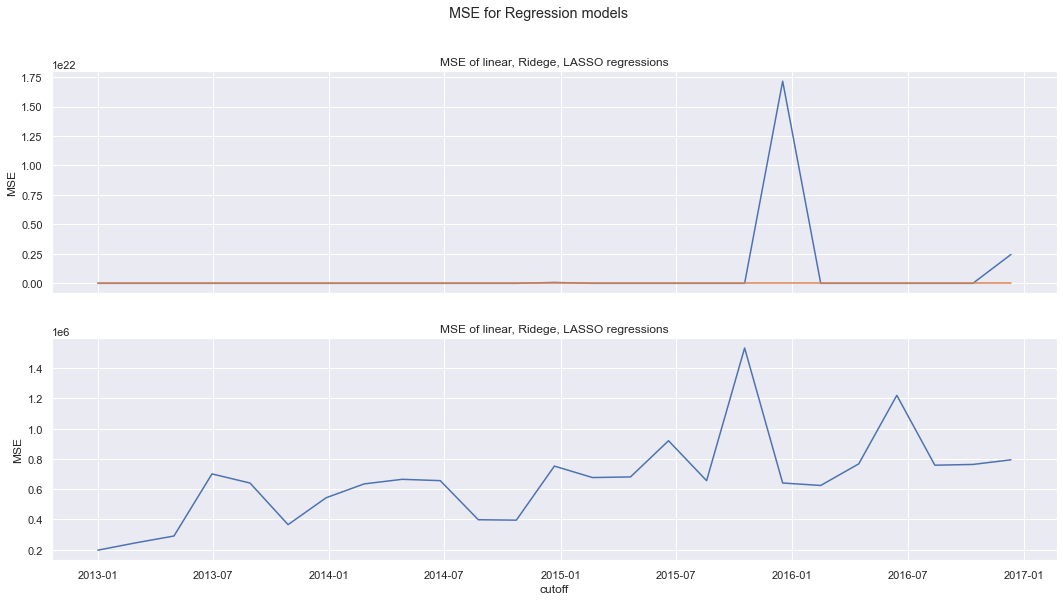

In [16]:
# ploting result
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(18,9))
fig.suptitle('MSE for Regression models')
axes[0].set_title('MSE of linear, Ridege, LASSO regressions')
axes[1].set_title('MSE of linear, Ridege, LASSO regressions')

sns.lineplot(ax = axes[0], data = lr_result2, x = 'cutoff', y = 'MSE')
sns.lineplot(ax = axes[0], data = rdg_result2, x = 'cutoff', y = 'MSE')
#sns.lineplot(ax = axes[0], data = las_result, x = 'cutoff', y = 'MSE')

sns.lineplot(ax = axes[1], data = rdg_result2, x = 'cutoff', y = 'MSE')
#sns.lineplot(ax = axes[1], data = las_result, x = 'cutoff', y = 'MSE')

#plt.savefig('regs_plot.jpg')